# Load Datasets

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2025-10-19 18:16:21.096685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760897781.351695      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760897781.422368      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
import os

def get_data_path(slug_name):
    base1 = f"/kaggle/input/{slug_name}"
    base2 = "/kaggle/input"
    if os.path.exists(base1):
        return base1
    elif os.path.exists(base2):
        return base2
    else:
        return "./Data"

data_dir = get_data_path("hotel-booking-analysis")

users = pd.read_csv(f"{data_dir}/users.csv")
hotels = pd.read_csv(f"{data_dir}/hotels.csv")
reviews = pd.read_csv(f"{data_dir}/reviews.csv")

# Data Cleaning

In [4]:
def clean_data(hotels, reviews, users):
    # merge all datasets
    tmp_df = pd.merge(hotels, reviews, on='hotel_id')
    df = pd.merge(tmp_df, users, on='user_id')
    
    # rename columns
    df.rename(columns={'country_x': 'hotel_country', 'country_y': 'user_country'}, inplace=True)

    # convert to datetime
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['join_date'] = pd.to_datetime(df['join_date'])
    
    # clean NaNs and duplicates
    df = df.drop_duplicates()
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    text_cols = df.select_dtypes(include=['object']).columns
    df[text_cols] = df[text_cols].fillna('Unknown')

    # create mapping before one-hot
    country_to_group = {
        'United States': 'North_America',
        'Canada': 'North_America',
        'Germany': 'Western_Europe',
        'France': 'Western_Europe',
        'United Kingdom': 'Western_Europe',
        'Netherlands': 'Western_Europe',
        'Spain': 'Western_Europe',
        'Italy': 'Western_Europe',
        'Russia': 'Eastern_Europe',
        'China': 'East_Asia',
        'Japan': 'East_Asia',
        'South Korea': 'East_Asia',
        'Thailand': 'Southeast_Asia',
        'Singapore': 'Southeast_Asia',
        'United Arab Emirates': 'Middle_East',
        'Turkey': 'Middle_East',
        'Egypt': 'Africa',
        'Nigeria': 'Africa',
        'South Africa': 'Africa',
        'Australia': 'Oceania',
        'New Zealand': 'Oceania',
        'Brazil': 'South_America',
        'Argentina': 'South_America',
        'India': 'South_Asia',
        'Mexico': 'North_America_Mexico'
    }

    # create the country_group column
    df['country_group'] = df['user_country'].map(country_to_group).fillna('Other')

    # binary mapping for gender
    df['user_gender'] = df['user_gender'].map({'Male': 0, 'Female': 1}).fillna(-1)
    
    # one-hot encode categorical columns
    categorical_cols = ['traveller_type', 'age_group', 'city']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    # drop unnecessary columns
    df = df.drop(columns=[
        'user_id', 'hotel_id', 'review_id','join_date', 'lat', 'lon','hotel_country', 'user_country','hotel_name', 'review_text', 'review_date'
    ], errors='ignore')

    return df
df = clean_data(hotels, reviews, users)

In [5]:
df.head()

,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,score_overall,score_cleanliness,score_comfort,...,city_Paris,city_Rio de Janeiro,city_Rome,city_Seoul,city_Shanghai,city_Singapore,city_Sydney,city_Tokyo,city_Toronto,city_Wellington
0,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.6,8.7,...,False,False,False,False,False,False,False,False,False,False
1,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.8,8.9,...,False,False,False,False,False,False,False,False,False,False
2,5,9.1,8.8,8.9,9.5,8.6,8.0,8.8,8.3,8.6,...,False,False,False,False,False,False,False,False,False,False
3,5,9.1,8.8,8.9,9.5,8.6,8.0,8.8,9.3,9.4,...,False,False,False,False,False,False,False,False,False,False
4,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.2,8.8,...,False,False,False,False,False,False,False,False,False,False


In [6]:
df.columns.tolist()

['star_rating',
 'cleanliness_base',
 'comfort_base',
 'facilities_base',
 'location_base',
 'staff_base',
 'value_for_money_base',
 'score_overall',
 'score_cleanliness',
 'score_comfort',
 'score_facilities',
 'score_location',
 'score_staff',
 'score_value_for_money',
 'user_gender',
 'country_group',
 'traveller_type_Couple',
 'traveller_type_Family',
 'traveller_type_Solo',
 'age_group_25-34',
 'age_group_35-44',
 'age_group_45-54',
 'age_group_55+',
 'city_Bangkok',
 'city_Barcelona',
 'city_Berlin',
 'city_Buenos Aires',
 'city_Cairo',
 'city_Cape Town',
 'city_Dubai',
 'city_Istanbul',
 'city_Lagos',
 'city_London',
 'city_Mexico City',
 'city_Moscow',
 'city_Mumbai',
 'city_New York',
 'city_Paris',
 'city_Rio de Janeiro',
 'city_Rome',
 'city_Seoul',
 'city_Shanghai',
 'city_Singapore',
 'city_Sydney',
 'city_Tokyo',
 'city_Toronto',
 'city_Wellington']

# Data-Engineering Questions

# Predictive Modeling Task

In [7]:
X = df[['star_rating',
 'cleanliness_base', 'comfort_base', 'facilities_base',
 'location_base', 'staff_base', 'value_for_money_base',
 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities',
 'score_location', 'score_staff', 'score_value_for_money', 'user_gender',
 'traveller_type_Couple', 'traveller_type_Family', 'traveller_type_Solo',
 'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55+',
 'city_Bangkok', 'city_Barcelona', 'city_Berlin', 'city_Buenos Aires',
 'city_Cairo', 'city_Cape Town', 'city_Dubai', 'city_Istanbul', 'city_Lagos',
 'city_London', 'city_Mexico City', 'city_Moscow', 'city_Mumbai', 'city_New York',
 'city_Paris', 'city_Rio de Janeiro', 'city_Rome', 'city_Seoul', 'city_Shanghai',
 'city_Singapore', 'city_Sydney', 'city_Tokyo', 'city_Toronto', 'city_Wellington']]

y = df['country_group']

In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_categorical = to_categorical(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical,
test_size=0.2, random_state=42)
print("\nLabel-encoded (numeric) y:")
print(y_encoded)

print("\nOne-hot encoded y (matrix):")
print(y_categorical)


Label-encoded (numeric) y:
[ 6 10  6 ... 10 10 10]

One-hot encoded y (matrix):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [9]:
model = Sequential([Input(shape=(X_train.shape[1],)),
layers.Dense(128, activation='relu'),
layers.Dense(64, activation='relu'),
layers.Dense(y_train.shape[1], activation='softmax') 
])
model.summary()

2025-10-19 18:16:37.348085: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,987 (58.54 KB)

 Trainable params: 14,987 (58.54 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy',
Precision(name='precision'),
Recall(name='recall')])


In [11]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3234 - loss: 2.0956 - precision: 0.3440 - recall: 0.0085 - val_accuracy: 0.3309 - val_loss: 1.9709 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3393 - loss: 1.9747 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3309 - val_loss: 1.9613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3402 - loss: 1.9631 - precision: 0.0689 - recall: 7.2285e-06 - val_accuracy: 0.3309 - val_loss: 1.9586 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3384 - loss: 1.9637 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3309 - val_loss: 1.9583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3395 - loss: 1.9548 - precision:

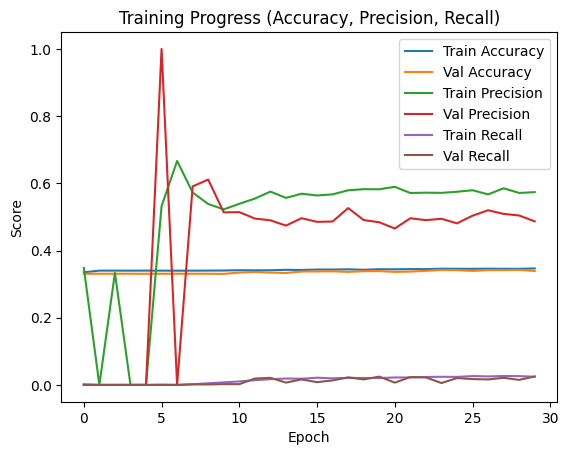

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Progress (Accuracy, Precision, Recall)')
plt.legend()
plt.show()


In [13]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test,
y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


Test Loss: 1.879211187362671
Test Accuracy: 0.33899998664855957
Test Precision: 0.5283687710762024
Test Recall: 0.02979999966919422


# Model Explainability